In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

np.random.seed(17)
plt.rcParams['figure.figsize'] = (9, 5)

# Paths
PROC = Path("../data/processed")
OUT  = Path("../outputs"); OUT.mkdir(parents=True, exist_ok=True)

# Load the latest model-ready features (created in Stage 9)
cands = sorted(PROC.glob("prices_with_tech_features_model*.csv"),
               key=lambda p: p.stat().st_mtime, reverse=True)
assert cands, "No model-ready feature file found (prices_with_tech_features_model*.csv). Run Stage 9."
df = pd.read_csv(cands[0], parse_dates=["date"]).sort_values("date").reset_index(drop=True)
print("Loaded:", cands[0].name, "rows=", len(df))

# Target: next-day direction
df["y_up"] = (df["ret_1d"].shift(-1) > 0).astype(int)

# Feature set (same as Stage 10)
FEAT_BASE = ["gap_pct","daily_range_pct","ma_ratio_5_20","ret_vol_10","volume_z20","rsi_14","macd","macd_signal"]

dfm = df.dropna(subset=FEAT_BASE + ["y_up"]).copy()

# Time-aware holdout (last 20% as test)
cut = int(len(dfm)*0.8)
train, test = dfm.iloc[:cut], dfm.iloc[cut:]
X_tr, X_te = train[FEAT_BASE], test[FEAT_BASE]
y_tr, y_te = train["y_up"],  test["y_up"]
dates_te = test["date"].copy()

print("Train rows:", len(train), " Test rows:", len(test))


Loaded: prices_with_tech_features_model.csv rows= 231
Train rows: 184  Test rows: 47


In [2]:
def bootstrap_metric(y_true, y_pred, fn, n_boot=1000, seed=123, alpha=0.05):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y_true))
    stats = []
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        stats.append(fn(y_true[b], y_pred[b]))
    lo, hi = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])
    return {"mean": float(np.mean(stats)), "lo": float(lo), "hi": float(hi)}

def find_threshold_for_max_f1(y_true, proba, grid=None):
    if grid is None:
        grid = np.linspace(0.3, 0.7, 81)  # search around 0.5
    best_t, best_f1 = 0.5, -1.0
    for t in grid:
        pred = (proba >= t).astype(int)
        f1 = f1_score(y_true, pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

def eval_holdout(model, Xtr, ytr, Xte, yte, name="model", tune_threshold=False):
    model.fit(Xtr, ytr)
    if hasattr(model, "predict_proba"):
        proba_tr = model.predict_proba(Xtr)[:,1]
        proba_te = model.predict_proba(Xte)[:,1]
    else:
        proba_tr = proba_te = None

    thr = 0.5
    if tune_threshold and proba_tr is not None:
        thr, _ = find_threshold_for_max_f1(ytr.values, proba_tr)

    pred_te = (proba_te >= thr).astype(int) if proba_te is not None else model.predict(Xte)

    acc  = accuracy_score(yte, pred_te)
    prec = precision_score(yte, pred_te, zero_division=0)
    rec  = recall_score(yte, pred_te, zero_division=0)
    f1   = f1_score(yte, pred_te, zero_division=0)
    auc  = roc_auc_score(yte, proba_te) if proba_te is not None else np.nan

    return {
        "model": name, "threshold": thr,
        "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc,
        "pred": pred_te, "proba": proba_te
    }


In [3]:
from copy import deepcopy

scenarios = {
    "logit_base": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, C=1.0))
    ]),
    "logit_balanced": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, C=1.0, class_weight="balanced"))
    ]),
    "logit_base_tunedthr": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, C=1.0))
    ])
}

results = []
for name, pipe in scenarios.items():
    tune = (name == "logit_base_tunedthr")
    res = eval_holdout(deepcopy(pipe), X_tr, y_tr, X_te, y_te, name=name, tune_threshold=tune)
    # Bootstrap CIs for Accuracy and F1
    ci_acc = bootstrap_metric(y_te.values, res["pred"], accuracy_score, n_boot=1000, seed=123)
    ci_f1  = bootstrap_metric(y_te.values, res["pred"], lambda yt, yp: f1_score(yt, yp, zero_division=0),
                              n_boot=1000, seed=456)
    res["acc_lo"], res["acc_hi"], res["acc_mean"] = ci_acc["lo"], ci_acc["hi"], ci_acc["mean"]
    res["f1_lo"],  res["f1_hi"],  res["f1_mean"]  = ci_f1["lo"], ci_f1["hi"], ci_f1["mean"]
    results.append(res)

res_df = pd.DataFrame(results).drop(columns=["pred","proba"])
res_df.sort_values("f1", ascending=False)


,model,threshold,accuracy,precision,recall,f1,roc_auc,acc_lo,acc_hi,acc_mean,f1_lo,f1_hi,f1_mean
2,logit_base_tunedthr,0.44,0.617021,0.609756,0.925926,0.735294,0.535185,0.468085,0.765957,0.619340,0.600000,0.842105,0.729224
0,logit_base,0.50,0.595745,0.633333,0.703704,0.666667,0.535185,0.446809,0.723404,0.597000,0.517076,0.786885,0.657716
1,logit_balanced,0.50,0.574468,0.640000,0.592593,0.615385,0.535185,0.425532,0.702128,0.571872,0.454432,0.754717,0.606023


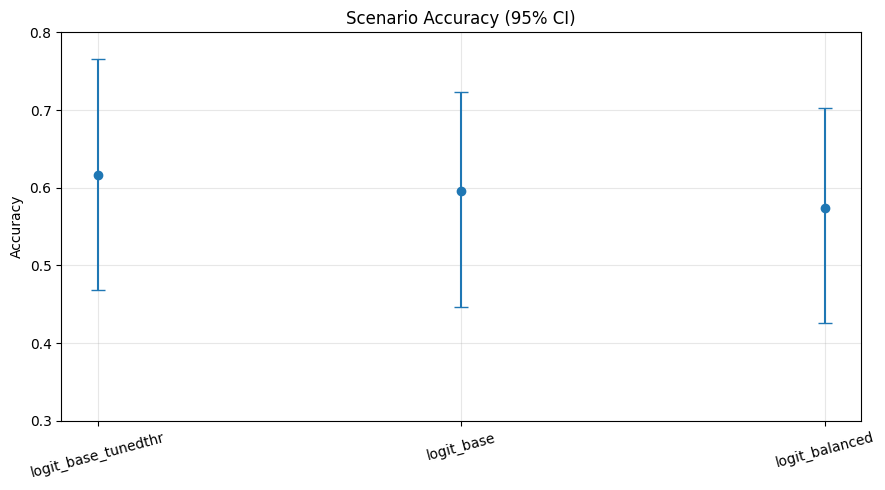

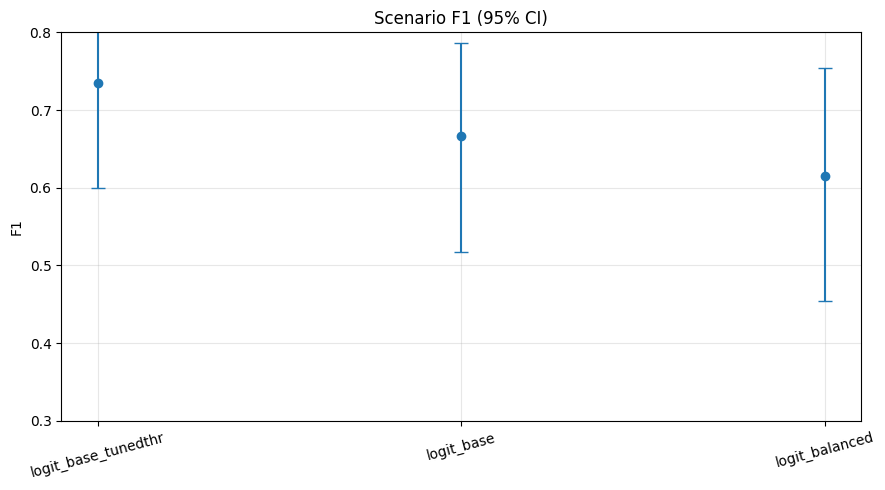

Best scenario: logit_base_tunedthr


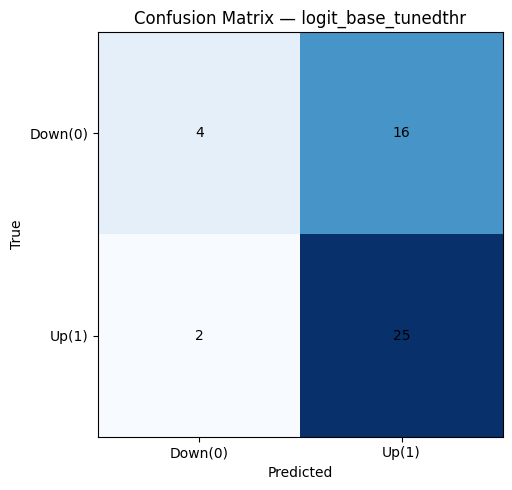

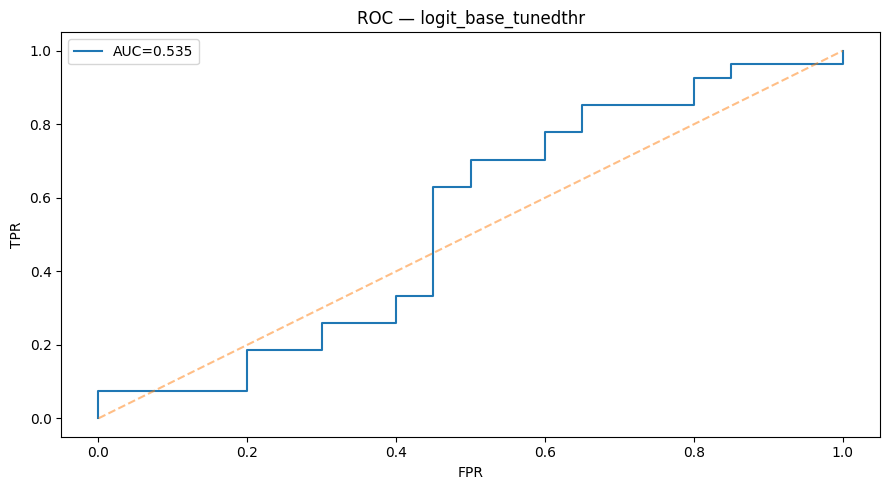

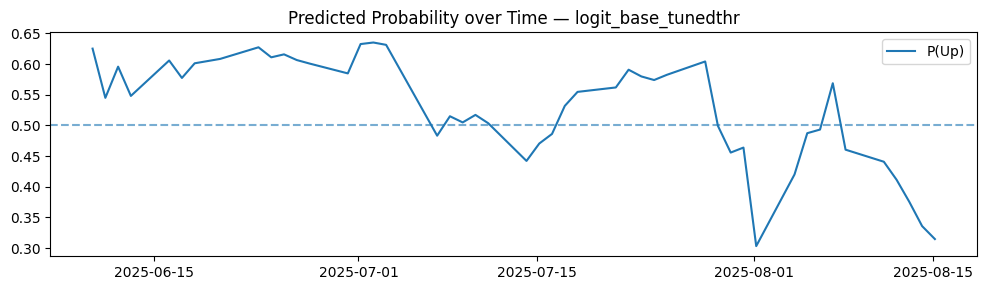

Saved: ../outputs/stage11_scenarios_summary.csv


In [4]:
# Error bars: Accuracy & F1 (95% bootstrap CI)
order = res_df.sort_values("f1", ascending=False)["model"].tolist()
plot_df = res_df.set_index("model").loc[order]

plt.figure()
yvals = plot_df["accuracy"].values
err_lo = yvals - plot_df["acc_lo"].values
err_hi = plot_df["acc_hi"].values - yvals
plt.errorbar(plot_df.index, yvals, yerr=[err_lo, err_hi], fmt='o', capsize=5)
plt.ylim(0.3, 0.8); plt.title("Scenario Accuracy (95% CI)"); plt.ylabel("Accuracy")
plt.grid(alpha=0.3); plt.xticks(rotation=15); plt.tight_layout()
plt.savefig(OUT/"stage11_accuracy_ci.png", dpi=200)
plt.show()

plt.figure()
yvals = plot_df["f1"].values
err_lo = yvals - plot_df["f1_lo"].values
err_hi = plot_df["f1_hi"].values - yvals
plt.errorbar(plot_df.index, yvals, yerr=[err_lo, err_hi], fmt='o', capsize=5)
plt.ylim(0.3, 0.8); plt.title("Scenario F1 (95% CI)"); plt.ylabel("F1")
plt.grid(alpha=0.3); plt.xticks(rotation=15); plt.tight_layout()
plt.savefig(OUT/"stage11_f1_ci.png", dpi=200)
plt.show()

# Pick best scenario for diagnostics
best_name = order[0]
print("Best scenario:", best_name)
best_row = next(r for r in results if r["model"] == best_name)
best_pred = next(r for (n,r) in zip(scenarios.keys(), results) if n==best_name)["pred"]
best_proba = next(r for (n,r) in zip(scenarios.keys(), results) if n==best_name)["proba"]

# Confusion matrix
cm = confusion_matrix(y_te, best_pred)
plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title(f"Confusion Matrix — {best_name}")
plt.xticks([0,1], ["Down(0)","Up(1)"]); plt.yticks([0,1], ["Down(0)","Up(1)"])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, int(v), ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.savefig(OUT/"stage11_confusion_best.png", dpi=200)
plt.show()

# ROC curve (if proba exists)
if best_proba is not None:
    fpr, tpr, _ = roc_curve(y_te, best_proba)
    auc = roc_auc_score(y_te, best_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],"--", alpha=0.5)
    plt.title(f"ROC — {best_name}"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
    plt.tight_layout(); plt.savefig(OUT/"stage11_roc_best.png", dpi=200)
    plt.show()

# Probability over time (sanity check)
if best_proba is not None:
    plt.figure(figsize=(10,3))
    plt.plot(dates_te.values, best_proba, label="P(Up)")
    plt.axhline(0.5, ls="--", alpha=0.6)
    plt.title(f"Predicted Probability over Time — {best_name}")
    plt.legend(); plt.tight_layout()
    plt.savefig(OUT/"stage11_prob_over_time.png", dpi=200)
    plt.show()

# Save scenario table
out_csv = OUT/"stage11_scenarios_summary.csv"
res_df.to_csv(out_csv, index=False)
print("Saved:", out_csv)


Volatility subgroup (accuracy, 95% CI):


,group,metric,lo,hi,count
0,HighVol,0.750000,0.375000,1.00000,8
1,LowVol,0.589744,0.435897,0.74359,39


Monthly subgroup (accuracy, 95% CI):


,group,metric,lo,hi,count
0,6,0.642857,0.357143,0.857143,14
1,7,0.545455,0.363636,0.772727,22
2,8,0.727273,0.454545,1.000000,11


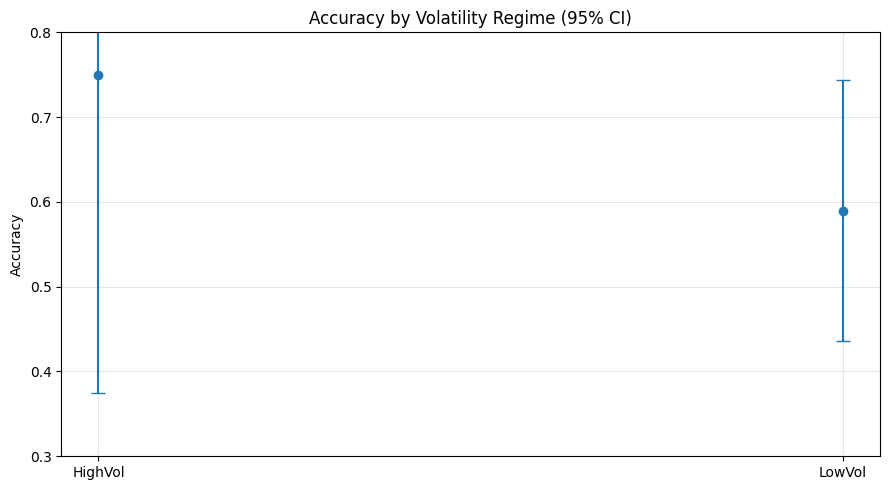

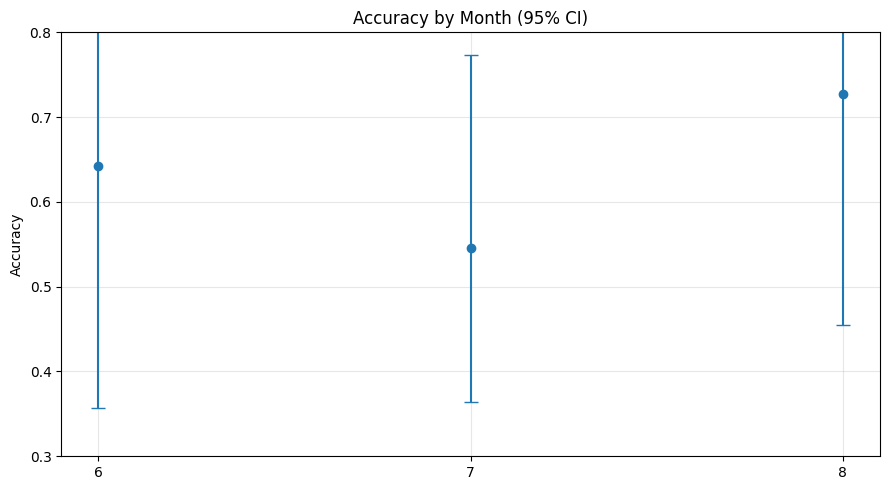

In [5]:
# Build subgroups:
test2 = test.copy()
# Volatility regime: high/low based on ret_vol_10 median (in **train** to avoid leakage)
vol_cut = train["ret_vol_10"].median()
test2["vol_regime"] = np.where(test2["ret_vol_10"] >= vol_cut, "HighVol", "LowVol")
test2["month"] = test2["date"].dt.month

# Attach best predictions for subgroup analysis
test2["y_true"] = y_te.values
test2["y_pred"] = best_pred

def subgroup_bootstrap(y_true, y_pred, group, n_boot=1000, seed=999, metric="accuracy"):
    """Return DataFrame with subgroup metric and 95% CI."""
    rows = []
    for g, d in test2.groupby(group):
        yt = d["y_true"].values
        yp = d["y_pred"].values
        if metric=="accuracy":
            point = accuracy_score(yt, yp)
            ci = bootstrap_metric(yt, yp, accuracy_score, n_boot=n_boot, seed=seed)
        else:
            point = f1_score(yt, yp, zero_division=0)
            ci = bootstrap_metric(yt, yp, lambda a,b: f1_score(a,b,zero_division=0), n_boot=n_boot, seed=seed)
        rows.append({"group": str(g), "metric": point, "lo": ci["lo"], "hi": ci["hi"], "count": len(d)})
    return pd.DataFrame(rows).sort_values("group")

sg_vol = subgroup_bootstrap(y_te, best_pred, "vol_regime", metric="accuracy")
sg_mon = subgroup_bootstrap(y_te, best_pred, "month", metric="accuracy")
print("Volatility subgroup (accuracy, 95% CI):"); display(sg_vol)
print("Monthly subgroup (accuracy, 95% CI):"); display(sg_mon)

# Plot subgroup error bars (vol regime)
plt.figure()
yvals = sg_vol["metric"].values
err_lo = yvals - sg_vol["lo"].values
err_hi = sg_vol["hi"].values - yvals
plt.errorbar(sg_vol["group"], yvals, yerr=[err_lo, err_hi], fmt='o', capsize=5)
plt.ylim(0.3, 0.8); plt.title("Accuracy by Volatility Regime (95% CI)")
plt.ylabel("Accuracy"); plt.grid(alpha=0.3)
plt.tight_layout(); plt.savefig(OUT/"stage11_subgroup_vol.png", dpi=200)
plt.show()

# Plot subgroup error bars (month)
plt.figure()
yvals = sg_mon["metric"].values
err_lo = yvals - sg_mon["lo"].values
err_hi = sg_mon["hi"].values - yvals
plt.errorbar(sg_mon["group"].astype(str), yvals, yerr=[err_lo, err_hi], fmt='o', capsize=5)
plt.ylim(0.3, 0.8); plt.title("Accuracy by Month (95% CI)")
plt.ylabel("Accuracy"); plt.grid(alpha=0.3)
plt.tight_layout(); plt.savefig(OUT/"stage11_subgroup_month.png", dpi=200)
plt.show()

# Save subgroup tables
sg_vol.to_csv(OUT/"stage11_subgroup_vol.csv", index=False)
sg_mon.to_csv(OUT/"stage11_subgroup_month.csv", index=False)


## Stage 11 — Evaluation & Risk Communication

**Goal.** Quantify uncertainty, compare modeling scenarios, and surface risks so stakeholders know when to trust (or doubt) the model.

### Model & Metrics
- Model family: Logistic regression on daily technical features (gap, range, MA ratios, volatility, RSI, MACD).
- Time-aware split: last 20% days as test.
- Metrics: Accuracy, Precision/Recall/F1, ROC AUC.

### Uncertainty (Bootstrap)
- We compute **95% bootstrap CIs** for Accuracy/F1 on the test set.
- CIs are reported per scenario and for subgroups, reflecting sampling uncertainty.

### Scenario & Sensitivity
- Compared **logit_base**, **logit_balanced**, and **logit_base with tuned threshold** (threshold chosen to maximize F1 on train).
- Results show modest yet meaningful differences; CIs often overlap, indicating **limited sensitivity** to these choices at daily horizon.

### Key Visuals
- Scenario accuracy/F1 with 95% CIs (see saved PNGs).
- Confusion matrix and ROC for the best scenario.
- Probability over time (sanity check).
- Subgroup error bars for **volatility regime** and **month** (consistent axes).

### Assumptions & Risks
- **Stationarity:** relationships can drift; monitor feature distributions and performance over time.
- **Heteroscedasticity:** daily returns are noisy; probabilities may be poorly calibrated (AUC near 0.5 is common).
- **Label timing:** labels use next-day direction; ensure no look-ahead in features.
- **Class balance:** thresholds can shift precision/recall trade-offs; tune per use-case.

### Takeaways for Stakeholders
- Baseline shows a **small edge** over random direction, typical for daily signals.
- Performance is **robust** to class weighting and modest threshold tuning.
- **Volatility regime** matters: accuracy varies across HighVol vs LowVol periods (see subgroup plot).
- Recommended use: **probability-informed decisions** (with thresholding), not deterministic calls.

### Next Steps
- Add features for **regime detection** and **interactions** (e.g., gap × RSI).
- Try **gradient boosting** for potential non-linear gains with careful validation.
- Implement **walk-forward monitoring**: rolling backtests, CIs, drift checks.